<a href="https://colab.research.google.com/github/itazap/MIE424-FinalProject/blob/main/Copy_of_MIE424_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIE424 Project

## Section 4. Load and Explore the Adult Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import time
from random import shuffle

In [2]:
!git clone https://github.com/mlohaus/SearchFair.git
%cd SearchFair

Cloning into 'SearchFair'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 86 (delta 32), reused 74 (delta 24), pack-reused 0
Unpacking objects: 100% (86/86), done.
/content/SearchFair


In [3]:
# Load data into pandas DataFrame
dataset = pd.read_csv('data/adult/adult.csv')

# Drop fnlwgt, education, education-num, capital-gain, capital-loss as Lohaus et al do
dataset = dataset.drop(columns=['fnlwgt', 'education', 'capital-gain', 'capital-loss'])
dataset

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,13,Divorced,Prof-specialty,Not-in-family,White,Female,36,United-States,<=50K
48838,64,?,9,Widowed,?,Other-relative,Black,Male,40,United-States,<=50K
48839,38,Private,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,50,United-States,<=50K
48840,44,Private,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,40,United-States,<=50K


In [4]:
def plotbargraph(data, column):
  ax = data[column].value_counts().plot(kind='bar',label='index',color=['C0', 'C1', 'C2', 'C3', 'C4'])
  for p in ax.patches:
      ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

  x = ax

  # Despine
  x.spines['right'].set_visible(False)
  x.spines['top'].set_visible(False)
  x.spines['left'].set_visible(False)

  # Switch off ticks
  x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw horizontal axis lines
  vals = x.get_yticks()
  for tick in vals:
      x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Remove title
  x.set_title((column + " Distribution").title(), weight='bold', size=12)

  # Set x-axis label
  x.set_xlabel("Label", labelpad=20, size=12)

  # Set y-axis label
  x.set_ylabel("Count", labelpad=20, size=12)

  # Format y-axis label
  x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

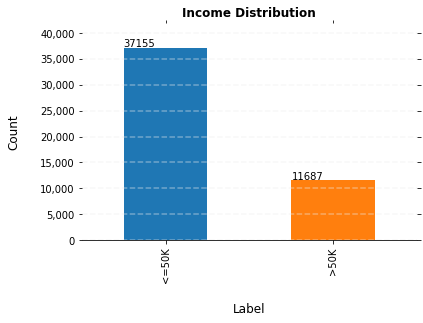

In [5]:
plotbargraph(dataset, 'income')

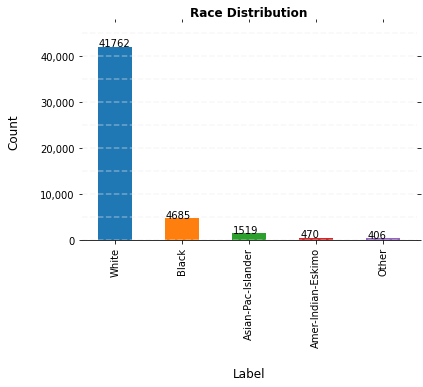

In [6]:
plotbargraph(dataset, 'race')

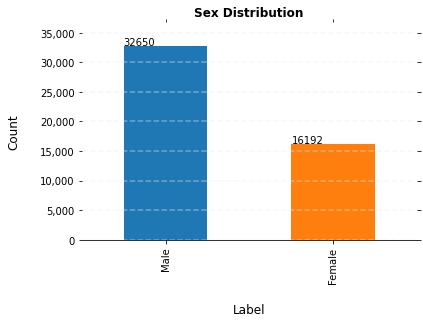

In [7]:
plotbargraph(dataset, 'sex')

In [8]:
def build_adult_data(dataset=dataset,sens_attribute = 'sex',load_data_size=None):
  """Build the Adult dataset.
  Source: UCI Machine Learning Repository.
  All Binary Mappings are defined in Lohaus' Too Relaxed To Be Fair research.
  We have kept the exact same mapping to make for clean comparisons. 
  
  Parameters
  ----------
  load_data_size: int
      The number of points to be loaded. If None, returns all data points unshuffled.
      If other than None, returns load_data_size shuffled.

  Returns
  ---------
  X: numpy array
      The feature input matrix after a binary mapping of attributes.
      Shape=(number_data_points, number_features)
  y: numpy array
      The classification labels (matrix) after a binary mapping of attributes.
      Shape=(number_data_points,).
  s: numpy array
      The sensitive feature vector after a binary mapping of attributes. 
      Shape=(number_data_points,).
  """
  
  def binary_mapping(tuple):
    # 'age'- Binary Cut-off: 37
    tuple['age'] = 1 if tuple['age'] > 37 else 0
    # 'workclass'- Binary Translation to Private/NonPrivate
    tuple['workclass'] = 'NonPrivate' if tuple['workclass'] != 'Private' else 'Private'
    # 'education-num'- Binary Cut-off: 9
    tuple['education-num'] = 1 if tuple['education-num'] > 9 else 0
    # 'maritial-status'- Binary Translation to Married-civ-spouse/nonMarriedcivspouse
    tuple['marital-status'] = "Marriedcivspouse" if tuple['marital-status'] == "Married-civ-spouse" else "nonMarriedcivspouse"
    # 'occupation'- Binary Translation to Craft-repair/NonCraftrepair
    tuple['occupation'] = "Craftrepair" if tuple['occupation'] == "Craft-repair" else "NonCraftrepair"
    # 'relationship'- Binary Translation to InFamily/Not-in-family
    tuple['relationship'] = "NotInFamily" if tuple['relationship'] == "Not-in-family" else "InFamily"
    # 'race'- Binary Translation to White/NonWhite
    tuple['race'] = 'NonWhite' if tuple['race'] != "White" else "White"
    # 'sex'- Binary Translation to Male/Female
    tuple['sex'] = 'Female' if tuple['sex'] != "Male" else 'Male'
    # 'hours-per-week'- Binary Cut-off: 40
    tuple['hours-per-week'] = 1 if tuple['hours-per-week'] > 40 else 0
    # 'native-country'- Binary Translation to United-States/NonUS
    tuple['native-country'] = "US" if tuple['native-country'] == "United-States" else "NonUS"
    
    return tuple

  df = dataset
  df = df.apply(binary_mapping, axis=1)

  # Convert Binary Mapping of Sensitive Attribute to {1,-1}
  if sens_attribute == 'sex':
    sensitive_attr_map = {'Male': 1, 'Female': -1}
    x_vars = ['age','workclass','education-num','marital-status','occupation','relationship','race','hours-per-week','native-country']
  elif sens_attribute == 'race':
    sensitive_attr_map = {'White': 1, 'NonWhite': -1}
    x_vars = ['age','workclass','education-num','marital-status','occupation','relationship','sex','hours-per-week','native-country']
  
  s = df[sens_attribute].map(sensitive_attr_map).astype(int)

  # Convert Binary Mapping of Label Attribute to {1,-1}
  label_map = {'>50K': 1, '<=50K': -1}
  y = df['income'].map(label_map).astype(int)

  # Build Input Matrix (Feature Set) as a proper DataFrame
  x = pd.DataFrame(data=None)
  for x_var in x_vars:
    x = pd.concat([x, pd.get_dummies(df[x_var],prefix=x_var, drop_first=False)], axis=1)

  # Return as numpy objects: Matrix/Vectors
  X = x.to_numpy()
  s = s.to_numpy()
  y = y.to_numpy()

  if load_data_size is not None:
      # Shuffle the data only if data_size is specified (Random detail from Paper code)
      perm = list(range(0, len(y)))
      shuffle(perm)
      X = X[perm][:load_data_size]
      y = y[perm][:load_data_size]
      s = s[perm][:load_data_size]

  # X = X[:, (X != 0).any(axis=0)]

  return X, y, s

def normalize(x):
	# scale to [-1, 1]
	x_ = (x - x.min()) / (x.max() - x.min()) * 2 - 1
	return x_

In [9]:
# Test
# build_adult_data(sens_attribute='race',load_data_size=None)

## Section 5.1 Implement Baseline Classifier

In [10]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
import sklearn.metrics.pairwise as kernels
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, GroupShuffleSplit

import cvxpy as cp

In [11]:
class BaselineModel(BaseEstimator):
    def __init__(self, l2_beta=0.001, kernel='linear', gamma=0.1, loss_name='hinge', lambda_max=1, max_iter=3000, solver='SCS', verbose=False,reason_points=0.5):

        self.l2_beta = l2_beta # Regularization parameter beta for the l2 regularization
        self.kernel = kernel # The SVM kernel to be used.. Options:['linear','rbf','poly']
        self.gamma = gamma # If kernel='rbf', gamma to be kernel width, If kernel='poly', gamma to be degree.
        self.loss_name = loss_name # Loss function to be used. Options:['hinge','logistic','squared','exponential']
        self.lambda_max = lambda_max # The max lambda value for the start of the binary search.
        self.max_iter = max_iter # The number of iterations.
        self.solver = solver # The solver to be used by cvxpy. Options:['SCS','ECOS'].
        self.verbose = verbose # If true, Overrides the default of hiding solver output.
        self.reason_points = reason_points # The ratio of points used as reasonable points for the similarity-based approach of SearchFair.

    def fit(self, x_train, y_train,s_train):

        # Set class variables
        self.x_train = x_train
        self.y_train = y_train
        self.s_train = s_train
        
        # Must call preprocess() after the datapoint size is given
        self._preprocess()
        # Construct the CVXPY problem
        self._construct_problem()
        # Optimize with given settings 
        self._optimize()
        
        return self

    def _preprocess(self):
       
        # Initialize the coef_ array as a class variable using cvxpy's built-in loss functions
        self.coef_ = None

        # Generate loss function based on the given loss_name
        if self.loss_name == 'logistic':
          self.loss_func = lambda z: cp.logistic(-z)
        elif self.loss_name == 'hinge':
          self.loss_func = lambda z: cp.pos(1.0 - z)
        elif self.loss_name == 'squared':
          self.loss_func = lambda z: cp.square(-z)
        elif self.loss_name == 'exponential':
          self.loss_func = lambda z: cp.exp(-z)
        else:
          self.loss_func = lambda z: cp.pos(1.0 - z) # Use Hinge-Loss unless specified otherwise

        if self.kernel == 'rbf':
          self.kernel_function = lambda X, Y: kernels.rbf_kernel(X, Y, self.gamma)
        elif self.kernel == 'poly':
          self.kernel_function = lambda X, Y: kernels.polynomial_kernel(X, Y, degree=self.gamma)
        elif self.kernel == 'linear':
            self.kernel_function = lambda X, Y: kernels.linear_kernel(X, Y) + 1
        else:
            self.kernel_function = kernel


        # Choose random reasonable points
        self.nmb_pts = len(self.s_train)
        if self.reason_points <= 1:
          self.reason_pts_index = list(range(int(self.nmb_pts * self.reason_points)))
        else:
          self.reason_pts_index = list(range(self.reason_points))
        self.nmb_reason_pts = len(self.reason_pts_index)

    def _construct_problem(self):

        # Variable to optimize
        self.params = cp.Variable((len(self.reason_pts_index), 1))
        # Parameter for Kernel Matrix
        self.kernel_matrix = cp.Parameter(shape=(self.x_train.shape[0], len(self.reason_pts_index)))
        
        self.bias = cp.Variable()

        # Loss Function to Minimize (with Regularization)
        self.loss = (1 / self.nmb_pts) * cp.sum(self.loss_func(cp.multiply(self.y_train.reshape(-1, 1), self.kernel_matrix @ self.params))) + self.l2_beta * cp.square(cp.norm(self.params, 2))
        
        # Final Problem Formulization
        self.prob = cp.Problem(cp.Minimize(self.loss))

    def _optimize(self):

        self.K_sim = self.kernel_function(self.x_train, self.x_train[self.reason_pts_index])
        self.kernel_matrix.value = self.K_sim

        if self.solver == 'SCS':
            self.prob.solve(solver=cp.SCS, max_iters=self.max_iter, verbose=self.verbose, warm_start=True)
        elif self.solver == 'ECOS':
            try:
                self.prob.solve(solver=cp.ECOS, max_iters=self.max_iter, verbose=self.verbose, warm_start=True)
            except Exception as e:
                self.prob.solve(solver=cp.SCS, max_iters=self.max_iter, verbose=self.verbose, warm_start=True)
    
        self.coef_ = self.params.value.squeeze()
    
    def predict(self, x_test):
        kernel_matrix = self.kernel_function(x_test, self.x_train[self.reason_pts_index])
        # Calculate Estimates
        y_hat = np.dot(self.coef_, np.transpose(kernel_matrix))
        
        return np.sign(y_hat)

## Section 5.2 Implement Testing Procedure with Fairness Scoring

In [12]:
class TestProcedure():
    def __init__(self,model):

        self.model = model

    def BuildDataset(self,sens_attribute,dataset=dataset,train_size = 1200):
        self.sens_attribute = sens_attribute

        # Build the Adult Dataset
        x_data, y_data, s_data = build_adult_data(dataset,sens_attribute,load_data_size=None)
        
        # Train Test split size.
        train_size = 1200
        
        # Split data into train and test.
        x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(x_data, y_data, s_data, train_size=train_size, shuffle=True)
        
        self.X_train = x_train
        self.y_train = y_train

        self.X_test = x_test
        self.y_test = y_test

        self.s_train = s_train
        self.s_test = s_test
                
    def BuildModel(self):
        
        start_time = time.time()
        
        self.model.fit(self.X_train,self.y_train,self.s_train)
        
        end_time = time.time()
        build_time = end_time - start_time
        
        return build_time
        
    def RunTest(self,sens_attribute,dataset=dataset):
        self.BuildDataset(sens_attribute,dataset=dataset)
        build_time = self.BuildModel()
        predictions = self.model.predict(self.X_test)
        prediction_accuracy = np.equal(self.y_test, predictions).mean()
        
        ddp,deo = self.compute_fairness_measures(predictions, self.y_test ,self.s_test)
        results = {"BuildTime":build_time,"PredictionAccuracy":prediction_accuracy,"DDP":ddp,"DEO":deo}
        self.PrintResults(results)
        return results
        
    def compute_fairness_measures(self, y_predicted, y_true, sens_attr):
        positive_rate_prot = self.get_positive_rate(y_predicted[sens_attr==-1], y_true[sens_attr==-1])
        positive_rate_unprot = self.get_positive_rate(y_predicted[sens_attr==1], y_true[sens_attr==1])
        true_positive_rate_prot = self.get_true_positive_rate(y_predicted[sens_attr==-1], y_true[sens_attr==-1])
        true_positive_rate_unprot = self.get_true_positive_rate(y_predicted[sens_attr==1], y_true[sens_attr==1])
        DDP = positive_rate_unprot - positive_rate_prot
        DEO = true_positive_rate_unprot - true_positive_rate_prot

        return DDP, DEO

    def get_positive_rate(self, y_predicted, y_true):
        tn, fp, fn, tp = confusion_matrix(y_true.astype(int), y_predicted.astype(int)).ravel()
        pr = (tp+fp) / (tp+fp+tn+fn)
        return pr

    def get_true_positive_rate(self, y_predicted, y_true):
        tn, fp, fn, tp = confusion_matrix(y_true.astype(int), y_predicted.astype(int)).ravel()
        tpr = tp / (tp+fn)
        return tpr
        
    def PrintResults(self,results):
      print("Sensitive Attribute:",self.sens_attribute)
      print("Kernel Type:",self.model.kernel)
      print("Loss Func:",self.model.loss_name)
      print("Run Time:",round(results['BuildTime'],4),"seconds")
      print("Prediction Accuracy:",str(round(results['PredictionAccuracy']*100,4)),"%")
      print("DDP Score:",str(round(results['DDP'],4)))
      print("DEO Score:",str(round(results['DEO'],4)))

In [13]:
baseline_linear_hinge = BaselineModel(kernel='linear',loss_name='hinge')
baseline_1_tester = TestProcedure(baseline_linear_hinge)
baseline_1_test_results = baseline_1_tester.RunTest(dataset=dataset,sens_attribute='sex')

Sensitive Attribute: sex
Kernel Type: linear
Loss Func: hinge
Run Time: 2.6473 seconds
Prediction Accuracy: 80.767 %
DDP Score: 0.25
DEO Score: 0.1781


In [14]:
baseline_rbf_hinge = BaselineModel(kernel='linear',loss_name='hinge')
baseline_2_tester = TestProcedure(baseline_rbf_hinge)
baseline_2_test_results = baseline_2_tester.RunTest(dataset=dataset,sens_attribute='race')

Sensitive Attribute: race
Kernel Type: linear
Loss Func: hinge
Run Time: 4.6404 seconds
Prediction Accuracy: 81.1847 %
DDP Score: 0.1066
DEO Score: 0.0999


## Section 5.2.1 Implement Baseline Hyperparameter Grid Search **for Accuracy**

In [15]:
# regularization parameter beta
sens_attribute = 'sex'

grid_search_model = BaselineModel()

beta_params = [0.0001, 0.001, 0.01] # For Linear Kernel
gamma_params = [0.01, 0.1, 1] # For RBF Kernel
kernel_params = ['linear','rbf']
cv_params = {'l2_beta': beta_params,'gamma': gamma_params,'kernel':kernel_params}

x_data, y_data, s_data = build_adult_data(dataset,sens_attribute,load_data_size=None)
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(x_data, y_data, s_data, train_size=1200, shuffle=True)

grid_clf = GridSearchCV(grid_search_model,cv_params, cv=4, n_jobs=1, scoring='accuracy')
grid_clf.fit(x_train, y_train, s_train = s_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=BaselineModel(gamma=0.1, kernel='linear', l2_beta=0.001,
                                     lambda_max=1, loss_name='hinge',
                                     max_iter=3000, reason_points=0.5,
                                     solver='SCS', verbose=False),
             iid='deprecated', n_jobs=1,
             param_grid={'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf'],
                         'l2_beta': [0.0001, 0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [16]:
grid_clf.cv_results_

{'mean_fit_time': array([2.26207989, 2.55815136, 2.82423693, 2.90453821, 1.87354714,
        2.28267783, 2.36054271, 2.72690403, 3.0434587 , 2.46705514,
        1.31818527, 1.78265589, 2.32581598, 2.52420217, 2.78287911,
        8.32777447, 1.77943224, 1.54147404]),
 'mean_score_time': array([0.00328791, 0.00201041, 0.00522256, 0.00743854, 0.00686359,
        0.00770164, 0.00187814, 0.00208026, 0.00222033, 0.00736058,
        0.00767964, 0.00666493, 0.00591266, 0.0019058 , 0.00183451,
        0.00695896, 0.0105899 , 0.00673378]),
 'mean_test_score': array([0.79916667, 0.8025    , 0.80083333, 0.81166667, 0.78416667,
        0.785     , 0.79916667, 0.8025    , 0.80083333, 0.80583333,
        0.80833333, 0.8075    , 0.79916667, 0.8025    , 0.80083333,
        0.79833333, 0.79916667, 0.815     ]),
 'param_gamma': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1,
                    0.1, 0.1, 1, 1, 1, 1, 1, 1],
              mask=[False, False, False, False, False, 

## Section 5.2.2 Implement Baseline Hyperparameter Grid Search **for DDP**

In [17]:
from sklearn.metrics.scorer import make_scorer

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [18]:
grid_split_counter = 1
def get_positive_rate(y_predicted, y_true):
  
  tn, fp, fn, tp = confusion_matrix(y_true, y_predicted).ravel()
  pr = (tp+fp) / (tp+fp+tn+fn)
  return pr

def DDP_Grid_Scoring(y_true,y_predicted,sens_attr,size):
  global grid_split_counter
  chunk_size = 1200/size
  sens_attribute = sens_attr[int((grid_split_counter - 1)*chunk_size): int(grid_split_counter*chunk_size)]
  if grid_split_counter == size:
    grid_split_counter = 1
  else:
    grid_split_counter += 1
  positive_rate_prot = get_positive_rate(y_predicted[sens_attribute==-1], y_true[sens_attribute==-1])
  positive_rate_unprot = get_positive_rate(y_predicted[sens_attribute==1], y_true[sens_attribute==1])
  DDP = abs(positive_rate_unprot - positive_rate_prot)
  return DDP


In [19]:
# regularization parameter beta
sens_attribute = 'sex'
size = 4

grid_search_model = BaselineModel()

beta_params = [0.0001, 0.001, 0.01] # For Linear Kernel
gamma_params = [0.01, 0.1, 1] # For RBF Kernel
kernel_params = ['linear','rbf']
cv_params = {'l2_beta': beta_params,'gamma': gamma_params,'kernel':kernel_params}

x_data, y_data, s_data = build_adult_data(dataset,sens_attribute,load_data_size=None)
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(x_data, y_data, s_data, train_size=1200, shuffle=True)


DDP_scorer = make_scorer(DDP_Grid_Scoring, greater_is_better=False, sens_attr = s_train, size = size)

fairness_grid_clf = GridSearchCV(grid_search_model,cv_params, cv=size, n_jobs=1, scoring=DDP_scorer)
fairness_grid_clf.fit(x_train, y_train, s_train = s_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=BaselineModel(gamma=0.1, kernel='linear', l2_beta=0.001,
                                     lambda_max=1, loss_name='hinge',
                                     max_iter=3000, reason_points=0.5,
                                     solver='SCS', verbose=False),
             iid='deprecated', n_jobs=1,
             param_grid={'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf'],
                         'l2_beta': [0.0001, 0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(DDP_Grid_Scoring, greater_is_better=False, sens_attr=[ 1 -1  1 ...  1  1  1], size=4),
             verbose=0)

In [20]:
fairness_grid_clf.cv_results_

{'mean_fit_time': array([ 1.25980341,  1.25864291,  1.26606649, 16.99792832,  1.90569109,
         2.06583601,  1.14928925,  1.10481709,  1.15970236,  2.11351049,
         1.57630903,  1.94435245,  1.12605518,  1.10870552,  1.0600214 ,
        12.41084987,  1.56964403,  1.47370154]),
 'mean_score_time': array([0.00570261, 0.00868762, 0.00611573, 0.0165382 , 0.01639307,
        0.01056653, 0.00457281, 0.00447029, 0.0098924 , 0.01281351,
        0.00913703, 0.00939643, 0.00432682, 0.00436646, 0.00564712,
        0.01154244, 0.00918221, 0.01172692]),
 'mean_test_score': array([-0.21331613, -0.21331613, -0.21331613, -0.21331613, -0.21331613,
         0.        , -0.21331613, -0.21331613, -0.21331613, -0.17726804,
        -0.21331613, -0.21331613, -0.21331613, -0.21331613, -0.21331613,
        -0.1561623 , -0.15336483, -0.15473062]),
 'param_gamma': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1,
                    0.1, 0.1, 1, 1, 1, 1, 1, 1],
              mask=

## Section 5.3 Implement Lohaus' SearchFair Algorithm

In [21]:
class SearchFair(BaseEstimator):
    """SearchFair
    Parameters
    ----------
    fairness_notions: string
        The name of the fairness notion that the classifier should respect. 'DDP' or 'DEO' can be used.
    fairness_regularizer: string
        The name of the fairness relaxation that is used as a regularizer. It can be 'linear', or 'wu'. For 'wu', the 'wu_bound' can be chosen.
    wu_bound: string
        The name of the function that is used in the bounds of Wu et al. It can be 'hinge', 'logistic', 'squared', 'exponential'
    reg_beta: float
        Regularization parameter Beta for the l2 regularization.
    kernel: string
        The kind of kernel that is used. It can be 'linear', 'rbf' or 'poly'. For 'rbf' and 'poly', the parameter gamma can be used.
    gamma: float
        For kernel='rbf', gamma is the kernel width, for kernel='poly', gamma is the degree.
    loss_name: string
        The name of the loss used. Possible values: 'hinge', 'logistic', 'squared', 'exponential'
    lambda_max: float
        The value of lambda_max for the start of the binary search.
    max_iter: int
        The number of iterations of the solver chosen.
    reason_points: float
        The ratio of points used as reasonable points for the similarity-based approach of SearchFair.
    stop_criterion: float
        If SearchFair finds a classifier that is at least as fair as 'stop_criterion', than it stops the search.
    max_search_iter: int
        The number of iterations for the binary search.
    solver: string
        The solver that is used by cvxpy. It can be 'SCS' or 'ECOS'.
    verbose: boolean
    Attributes
    ----------
    coef_: numpy array
        An array containing the trained weights for each reasonable point.
    reason_pts_index: numpy array
        An array containing the indices of the reasonable points in the training data.
    Notes
    ----------
    """

    def __init__(self, fairness_notion='DDP', fairness_regularizer='wu', wu_bound='hinge', reg_beta=0.001, kernel='linear', gamma=None, loss_name='hinge', lambda_max=1, max_iter=3000, reason_points=0.5, stop_criterion=0.01, max_search_iter=10, solver='SCS', verbose=False):

        self.reg_beta = reg_beta
        self.fairness_notion = fairness_notion
        self.max_iter = max_iter
        self.max_search_iter = max_search_iter
        self.solver = solver
        self.verbose = verbose
        self.stop_criterion = stop_criterion
        self.reason_points = reason_points
        self.lambda_max = lambda_max
        self.wu_bound = wu_bound
        self.fairness_regularizer = fairness_regularizer
        self.wu_bound = wu_bound
        self.gamma = gamma
        self.loss_name = loss_name
        self.kernel = kernel

    def fit(self, x_train, y_train, s_train=None):
        """Fits SearchFair on the given training data.
        Parameters
        ----------
        x_train: numpy array
            The features of the training data with shape=(number_points,number_features).
        y_train: numpy array
            The class labels of the training data with shape=(number_points,).
        s_train: numpy array
            The binary sensitive attributes of the training data with shape=(number_points,).
        Returns
        ----------
        self: object
        """

        self.x_train = x_train
        self.y_train = y_train
        self.s_train = s_train

        if self.verbose:
            print("Preprocessing...")
        self._preprocess()

        lbda_min, lbda_max = 0, self.lambda_max

        def learn(reg, bound='upper'):
            # If bound is None, we have decided which one to use, and we are in the middle of the binary search

            self.fairness_lambda = reg
            if bound is not None:
                self._construct_problem(bound=bound)
            self._optimize()
            DDP, DEO = self.compute_fairness_measures(self.predict(x_train), y_train, s_train)
            if self.fairness_notion == 'DDP':
                fair_value = DDP
            else:
                fair_value = DEO
            if self.verbose: print("Obtained:",self.fairness_notion, "= %0.4f with lambda = %0.4f" % (fair_value, reg))
            return fair_value, self.coef_.copy()

        criterion = False

        bound = 'upper' # even though an upper bound is specified, since lambda_min is 0, it falls away
        if self.verbose: print("Testing lambda_min: %0.2f" % lbda_min)
        min_fair_measure, min_alpha = learn(lbda_min, bound=bound)
        if np.sign(min_fair_measure) < 0: bound = 'lower'
        if self.verbose: print("Testing lambda_max: %0.2f" % lbda_max)
        max_fair_measure, max_alpha = learn(lbda_max, bound)

        if np.abs(min_fair_measure) < np.abs(max_fair_measure):
            best_lbda, best_fair_measure = lbda_min, min_fair_measure
            best_alpha = min_alpha
        else:
            best_lbda, best_fair_measure = lbda_max, max_fair_measure
            best_alpha = max_alpha
        if  np.abs(best_fair_measure) < self.stop_criterion:
            print("Classifier is fair enough with lambda = {:.4f}".format(best_lbda))
        elif np.sign(min_fair_measure) == np.sign(max_fair_measure):
            print('Fairness value has the same sign for lambda_min and lambda_max.')
            print('Either try a different fairness regularizer or change the values of lambda_min and lambda_max') # Possibly, there could be a few more tries by reducing lambda.
        else:
            search_iter = 0
            if self.verbose: print("Starting Binary Search...")
            while not criterion and search_iter < self.max_search_iter:
                lbda_new = (lbda_min + lbda_max) / 2

                if self.verbose:
                    print(10*'-'+"Iteration #%0.0f" % search_iter + 10*'-')
                    print("Testing new Lambda: %0.4f" % lbda_new)

                new_rd, new_alpha = learn(lbda_new, None)
                if np.abs(new_rd) < np.abs(best_fair_measure):
                    best_fair_measure = new_rd
                    best_lbda = lbda_new
                    best_alpha = new_alpha.copy()

                if np.sign(new_rd) == np.sign(min_fair_measure):
                    min_fair_measure = new_rd
                    lbda_min = lbda_new
                else:
                    max_fair_measure = new_rd
                    lbda_max = lbda_new
                if np.abs(new_rd) < self.stop_criterion:
                    criterion = True

                search_iter += 1
            if search_iter==self.max_search_iter and self.verbose:
                print("Hit maximum iterations of Binary Search.")
            elif self.verbose:
                print("Sufficient fairness obtained before maximum iterations were reached.")

        if self.verbose: print(10*'-'+"Found Lambda %0.4f with fairness %0.4f" % (best_lbda, best_fair_measure)+10*'-')
        self.coef_ = best_alpha.copy()

        return self

    def predict(self, x_test):
        """Predict the label of test data.
        Parameters
        ----------
        x_test: numpy array
            The features of the test data with shape=(number_points,number_features).
        Returns
        ----------
        y_hat: numpy array
            The predicted class labels with shape=(number_points,).
        """
        kernel_matr = self.kernel_function(x_test, self.x_train[self.reason_pts_index])
        y_hat = np.dot(self.coef_, np.transpose(kernel_matr))
        return np.sign(y_hat)

    def _preprocess(self):
        """Setting the attributes loss_func, kernel_function, and weight_vector,
        which depends on the fairness notion, and is used in fairness related objects.
        """
        self.coef_ = None
        self.fairness_lambda = 0
        if self.loss_name == 'logistic':
            self.loss_func = lambda z: cp.logistic(-z)
        elif self.loss_name == 'hinge':
            self.loss_func = lambda z: cp.pos(1.0 - z)
        elif self.loss_name == 'squared':
            self.loss_func = lambda z: cp.square(-z)
        elif self.loss_name == 'exponential':
            self.loss_func = lambda z: cp.exp(-z)
        else:
            print('Using default loss: hinge loss.')
            self.loss_func = lambda z: cp.pos(1.0 - z)

        if self.kernel == 'rbf':
            self.kernel_function = lambda X, Y: kernels.rbf_kernel(X, Y, self.gamma)
        elif self.kernel == 'poly':
            self.kernel_function = lambda X, Y: kernels.polynomial_kernel(X, Y, degree=self.gamma)
        elif self.kernel == 'linear':
            self.kernel_function = lambda X, Y: kernels.linear_kernel(X, Y) + 1
        else:
            self.kernel_function = kernel

        if self.wu_bound == 'logistic':
            self.cvx_kappa = lambda z: cp.logistic(z)
            self.cvx_delta = lambda z: 1 - cp.logistic(-z)
        elif self.wu_bound == 'hinge':
            self.cvx_kappa = lambda z: cp.pos(1 + z)
            self.cvx_delta = lambda z: 1 - cp.pos(1 - z)
        elif self.wu_bound == 'squared':
            self.cvx_kappa = lambda z: cp.square(1 + z)
            self.cvx_delta = lambda z: 1 - cp.square(1 - z)
        elif self.wu_bound == 'exponential':
            self.cvx_kappa = lambda z: cp.exp(z)
            self.cvx_delta = lambda z: 1 - cp.exp(-z)
        else:
            print('Using default bound with hinge.')
            self.cvx_kappa = lambda z: cp.pos(1 + z)
            self.cvx_delta = lambda z: 1 - cp.pos(1 - z)

        self.nmb_pts = len(self.s_train)
        self.nmb_unprotected = np.sum(self.s_train == 1)
        self.prob_unprot = self.nmb_unprotected / self.nmb_pts
        self.prob_prot = 1 - self.prob_unprot

        self.nmb_pos = np.sum(self.y_train == 1)
        self.nmb_prot_pos = np.sum(self.y_train[self.s_train == -1] == 1)
        self.prob_prot_pos = self.nmb_prot_pos / self.nmb_pos
        self.prob_unprot_pos = 1 - self.prob_prot_pos

        # Create weights that are necessary for the fairness constraint
        if self.fairness_notion == 'DDP':
            normalizer = self.nmb_pts
            self.weight_vector = np.array(
                [1.0 / self.prob_prot if self.s_train[i] == -1 else 1.0 / self.prob_unprot for i in range(len(self.s_train))]).reshape(-1,1)
            self.weight_vector = (1 / normalizer) * self.weight_vector
        elif self.fairness_notion == 'DEO':
            normalizer = self.nmb_pos
            self.weight_vector = np.array(
                [1.0 / self.prob_prot_pos if self.s_train[i] == -1 else 1.0 / self.prob_unprot_pos for i in range(len(self.s_train))]).reshape(-1, 1)
            self.weight_vector = 0.5 * (self.y_train.reshape(-1, 1) + 1) * self.weight_vector
            self.weight_vector = (1 / normalizer) * self.weight_vector

        # Choose random reasonable points
        if self.reason_points <= 1:
            self.reason_pts_index = list(range(int(self.nmb_pts * self.reason_points)))
        else:
            self.reason_pts_index = list(range(self.reason_points))
        self.nmb_reason_pts = len(self.reason_pts_index)

    def _construct_problem(self, bound='upper'):
        """ Construct the cvxpy minimization problem.
        It depends on the fairness regularizer chosen.
        """

        # Variable to optimize
        self.alpha_var = cp.Variable((len(self.reason_pts_index), 1))
        # Parameter for Kernel Matrix
        self.kernel_matrix = cp.Parameter(shape=(self.x_train.shape[0], len(self.reason_pts_index)))
        self.fair_reg_cparam = cp.Parameter(nonneg=True)


        # Form SVM with L2 regularization
        if self.fairness_lambda == 0:
            self.loss = cp.sum(self.loss_func(cp.multiply(self.y_train.reshape(-1, 1), self.kernel_matrix @ self.alpha_var))) + self.reg_beta * self.nmb_pts * cp.square(
                cp.norm(self.alpha_var, 2))
        else:
            sy_hat = cp.multiply(self.s_train.reshape(-1, 1), self.kernel_matrix @ self.alpha_var)

            if self.fairness_regularizer == 'wu':
                if bound == 'upper':
                    fairness_relaxation = cp.sum(cp.multiply(self.weight_vector, self.cvx_kappa(sy_hat))) - 1
                else:
                    fairness_relaxation = -1 * cp.sum(cp.multiply(self.weight_vector, self.cvx_delta(sy_hat))) - 1


            elif self.fairness_regularizer == 'linear':
                if bound == 'upper':
                    fairness_relaxation = cp.sum(cp.multiply(self.weight_vector, self.kernel_matrix @ self.alpha_var))
                else:
                    fairness_relaxation = -1 * cp.sum(cp.multiply(self.weight_vector, self.kernel_matrix @ self.alpha_var))

            if self.reg_beta == 0:
                self.loss = (1/self.nmb_pts) * cp.sum(self.loss_func(cp.multiply(self.y_train.reshape(-1, 1), self.kernel_matrix @ self.alpha_var))) + \
                                self.fair_reg_cparam * fairness_relaxation
            else:
                self.loss = (1 / self.nmb_pts) * cp.sum(self.loss_func(cp.multiply(self.y_train.reshape(-1, 1), self.kernel_matrix @ self.alpha_var))) + \
                            self.fair_reg_cparam * fairness_relaxation + self.reg_beta * cp.square(cp.norm(self.alpha_var, 2))

        self.prob = cp.Problem(cp.Minimize(self.loss))

    def _optimize(self):
        """Conduct the optimization of the created problem by using ECOS or SCS
        with cvxpy. 
        """

        # Compute and initialize kernel matrix
        self.K_sim = self.kernel_function(self.x_train, self.x_train[self.reason_pts_index])
        self.kernel_matrix.value = self.K_sim
        self.fair_reg_cparam.value = self.fairness_lambda

        if self.verbose == 2:
            verbose = True
        else:
            verbose = False
        if self.solver == 'SCS':
            self.prob.solve(solver=cp.SCS, max_iters=self.max_iter, verbose=verbose, warm_start=True)
        elif self.solver == 'ECOS':
            try:
                self.prob.solve(solver=cp.ECOS, max_iters=self.max_iter, verbose=verbose, warm_start=True)
            except Exception as e:
                self.prob.solve(solver=cp.SCS, max_iters=self.max_iter, verbose=verbose, warm_start=True)
        if verbose:
            print('status %s ' % self.prob.status)
            print('value %s ' % self.prob.value)
        self.coef_ = self.alpha_var.value.squeeze()
    def compute_fairness_measures(self, y_predicted, y_true, sens_attr):
        """Compute value of demographic parity and equality of opportunity for given predictions.
        Parameters
        ----------
        y_predicted: numpy array
            The predicted class labels of shape=(number_points,).
        y_true: numpy array
            The true class labels of shape=(number_points,).
        sens_attr: numpy array
            The sensitive labels of shape=(number_points,).
        Returns
        ----------
        DDP: float
            The difference of demographic parity.
        DEO: float
            The difference of equality of opportunity.
        """
        positive_rate_prot = self.get_positive_rate(y_predicted[sens_attr==-1], y_true[sens_attr==-1])
        positive_rate_unprot = self.get_positive_rate(y_predicted[sens_attr==1], y_true[sens_attr==1])
        true_positive_rate_prot = self.get_true_positive_rate(y_predicted[sens_attr==-1], y_true[sens_attr==-1])
        true_positive_rate_unprot = self.get_true_positive_rate(y_predicted[sens_attr==1], y_true[sens_attr==1])
        DDP = positive_rate_unprot - positive_rate_prot
        DEO = true_positive_rate_unprot - true_positive_rate_prot

        return DDP, DEO

    def get_positive_rate(self, y_predicted, y_true):
        """Compute the positive rate for given predictions of the class label.
        Parameters
        ----------
        y_predicted: numpy array
            The predicted class labels of shape=(number_points,).
        y_true: numpy array
            The true class labels of shape=(number_points,).
        Returns
        ---------
        pr: float
            The positive rate.
        """
        tn, fp, fn, tp = confusion_matrix(y_true, y_predicted).ravel()
        pr = (tp+fp) / (tp+fp+tn+fn)
        return pr

    def get_true_positive_rate(self, y_predicted, y_true):
        """Compute the true positive rate for given predictions of the class label.
        Parameters
        ----------
        y_predicted: numpy array
            The predicted class labels of shape=(number_points,).
        y_true: numpy array
            The true class labels of shape=(number_points,).
        Returns
        ---------
        tpr: float
            The true positive rate.
        """
        tn, fp, fn, tp = confusion_matrix(y_true, y_predicted).ravel()
        tpr = tp / (tp+fn)
        return tpr

## Section 6	Results & Discussion

### DDP

In [22]:
fairness_notion = 'DDP'  
kernel = 'linear' 
verbose = False

SearchFair_Sex_DDP_LinearKernel_Hinge = SearchFair(kernel=kernel, fairness_notion=fairness_notion, verbose=verbose)
SearchFair_tester = TestProcedure(SearchFair_Sex_DDP_LinearKernel_Hinge)
SearchFair_tester_results = SearchFair_tester.RunTest(dataset=dataset,sens_attribute='sex')

Sensitive Attribute: sex
Kernel Type: linear
Loss Func: hinge
Run Time: 12.8848 seconds
Prediction Accuracy: 76.0547 %
DDP Score: 0.0
DEO Score: 0.0


In [23]:
fairness_notion = 'DDP'  
kernel = 'linear' 
verbose = False

SearchFair_Race_DDP_LinearKernel_Hinge = SearchFair(kernel=kernel, fairness_notion=fairness_notion, verbose=verbose)
SearchFair_tester = TestProcedure(SearchFair_Race_DDP_LinearKernel_Hinge)
SearchFair_tester_results = SearchFair_tester.RunTest(dataset=dataset,sens_attribute='race')

Sensitive Attribute: race
Kernel Type: linear
Loss Func: hinge
Run Time: 12.3818 seconds
Prediction Accuracy: 76.0778 %
DDP Score: 0.0
DEO Score: 0.0


In [24]:
fairness_notion = 'DDP'  
kernel = 'rbf' 
verbose = False

SearchFair_Sex_DDP_RBFKernel_Hinge = SearchFair(kernel=kernel, fairness_notion=fairness_notion, verbose=verbose)
SearchFair_tester = TestProcedure(SearchFair_Sex_DDP_RBFKernel_Hinge)
SearchFair_tester_results = SearchFair_tester.RunTest(dataset=dataset,sens_attribute='sex')

Sensitive Attribute: sex
Kernel Type: rbf
Loss Func: hinge
Run Time: 21.7692 seconds
Prediction Accuracy: 76.0841 %
DDP Score: 0.0
DEO Score: 0.0


In [25]:
fairness_notion = 'DDP'  
kernel = 'rbf' 
verbose = False

SearchFair_Race_DDP_RBFKernel_Hinge = SearchFair(kernel=kernel, fairness_notion=fairness_notion, verbose=verbose)
SearchFair_tester = TestProcedure(SearchFair_Race_DDP_RBFKernel_Hinge)
SearchFair_tester_results = SearchFair_tester.RunTest(dataset=dataset,sens_attribute='race')

Sensitive Attribute: race
Kernel Type: rbf
Loss Func: hinge
Run Time: 41.3875 seconds
Prediction Accuracy: 80.2779 %
DDP Score: 0.0255
DEO Score: -0.0557


### DEO

In [26]:
fairness_notion = 'DEO'  
kernel = 'linear' 
verbose = False

SearchFair_Sex_DEO_LinearKernel_Hinge = SearchFair(kernel=kernel, fairness_notion=fairness_notion, verbose=verbose)
SearchFair_tester = TestProcedure(SearchFair_Sex_DEO_LinearKernel_Hinge)
SearchFair_tester_results = SearchFair_tester.RunTest(dataset=dataset,sens_attribute='sex')

Classifier is fair enough with lambda = 1.0000
Sensitive Attribute: sex
Kernel Type: linear
Loss Func: hinge
Run Time: 7.8842 seconds
Prediction Accuracy: 76.0484 %
DDP Score: 0.0
DEO Score: 0.0


In [27]:
fairness_notion = 'DEO'  
kernel = 'linear' 
verbose = False

SearchFair_Race_DEO_LinearKernel_Hinge = SearchFair(kernel=kernel, fairness_notion=fairness_notion, verbose=verbose)
SearchFair_tester = TestProcedure(SearchFair_Race_DEO_LinearKernel_Hinge)
SearchFair_tester_results = SearchFair_tester.RunTest(dataset=dataset,sens_attribute='race')

Sensitive Attribute: race
Kernel Type: linear
Loss Func: hinge
Run Time: 62.6676 seconds
Prediction Accuracy: 80.7334 %
DDP Score: 0.0957
DEO Score: 0.0171


In [28]:
fairness_notion = 'DEO'  
kernel = 'rbf' 
verbose = False

SearchFair_Sex_DEO_RBFKernel_Hinge = SearchFair(kernel=kernel, fairness_notion=fairness_notion, verbose=verbose)
SearchFair_tester = TestProcedure(SearchFair_Sex_DEO_RBFKernel_Hinge)
SearchFair_tester_results = SearchFair_tester.RunTest(dataset=dataset,sens_attribute='sex')

Sensitive Attribute: sex
Kernel Type: rbf
Loss Func: hinge
Run Time: 66.1135 seconds
Prediction Accuracy: 80.6494 %
DDP Score: 0.2368
DEO Score: 0.1901


In [29]:
fairness_notion = 'DEO'  
kernel = 'rbf' 
verbose = False

SearchFair_Race_DEO_RBFKernel_Hinge = SearchFair(kernel=kernel, fairness_notion=fairness_notion, verbose=verbose)
SearchFair_tester = TestProcedure(SearchFair_Race_DEO_RBFKernel_Hinge)
SearchFair_tester_results = SearchFair_tester.RunTest(dataset=dataset,sens_attribute='race')

Sensitive Attribute: race
Kernel Type: rbf
Loss Func: hinge
Run Time: 60.7405 seconds
Prediction Accuracy: 80.7187 %
DDP Score: 0.1482
DEO Score: 0.232
